## PREPARING THE ESSENTIAL LIBRARIES

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import FuncFormatter

In [2]:
# Setting plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## DATA UNDERSTANDING & IMPORTING

In [3]:
df = pd.read_csv("The_original_data_(uncleaned).csv", encoding='ISO-8859-1')

print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Quick data overview
print("\nDATA OVERVIEW:")
df.info()
print("\nFirst 5 rows:")
print(df.head())
print("\nStatistical Summary:")
print(df.describe(include='all'))
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Return invoices (starting with 'C'): {df['InvoiceNo'].astype(str).str.startswith('C').sum()}")
print(f"\nCountry distribution:\n{df['Country'].value_counts().head(10)}")

Dataset Shape: (541909, 8)
Memory Usage: 173.12 MB

DATA OVERVIEW:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB

First 5 rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNIT

In [4]:
# Showing the number of rows where the UnitPrice and Quantity columns have values ≤ 0
quantity = (df['Quantity'] <= 0).sum()
print("- Số lượng các dòng có ô của cột 'Quanity' bé hơn hoặc bằng 0: ", quantity)
unitPrice = (df['UnitPrice'] <= 0).sum()
print("- Số lượng các dòng có ô của cột 'UnitPrice' bé hơn hoặc bằng 0: ", unitPrice)

- Số lượng các dòng có ô của cột 'Quanity' bé hơn hoặc bằng 0:  10624
- Số lượng các dòng có ô của cột 'UnitPrice' bé hơn hoặc bằng 0:  2517


## DATA PREPARATION & CLEANING

In [5]:
# Removing duplicates
initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"- Đã loại bỏ {initial_rows - len(df)} dòng bị trùng lặp")

# Dealing with missing values
df['CustomerID'] = df['CustomerID'].fillna('Unknown')
df['Description'] = df['Description'].fillna('Unidentified')
df['CustomerID'] = df['CustomerID'].astype(str)

# Removing the rows with the UnitPrice and Quantity columns have values <= 0
df.drop(df[(df['Quantity'] <= 0) | (df['UnitPrice'] <= 0)].index, inplace=True)

# Checking whether it exists the number of rows where the UnitPrice and Quantity columns have values ≤ 0
quantity = (df['Quantity'] <= 0).sum()
print("- Số lượng các dòng có ô của cột 'Quanity' bé hơn hoặc bằng 0: : ", quantity)
unitPrice = (df['UnitPrice'] <= 0).sum()
print("- Số lượng các dòng có ô của cột 'UnitPrice' bé hơn hoặc bằng 0: ", unitPrice)

# Converting date and creating temporal features
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Cleaning text fields
df['Description'] = df['Description'].str.strip().str.upper()
df['Country'] = df['Country'].str.strip().str.title()

# Creating derived features
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['TotalPrice'] = df['TotalPrice'].round(2)
df['InvoiceYear'] = df['InvoiceDate'].dt.year
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
df['InvoiceDay'] = df['InvoiceDate'].dt.day
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceWeekday'] = df['InvoiceDate'].dt.day_name()


# Creating seasonal features
def get_season(month):
    if month in [10, 11, 12]: 
        return 'Winter'
    elif month in [1, 2, 3]: 
        return 'Spring'
    elif month in [4, 5, 6]: 
        return 'Summer'
    else: 
        return 'Autumn'

df['Season'] = df['InvoiceMonth'].apply(get_season)

# Saving cleaned data into a new file
clean_path = "The_cleaned_data.csv"
df.to_csv(clean_path, index=False)
 
df.info()


- Đã loại bỏ 5268 dòng bị trùng lặp
- Số lượng các dòng có ô của cột 'Quanity' bé hơn hoặc bằng 0: :  0
- Số lượng các dòng có ô của cột 'UnitPrice' bé hơn hoặc bằng 0:  0
<class 'pandas.core.frame.DataFrame'>
Index: 524878 entries, 0 to 541908
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   InvoiceNo       524878 non-null  object        
 1   StockCode       524878 non-null  object        
 2   Description     524878 non-null  object        
 3   Quantity        524878 non-null  int64         
 4   InvoiceDate     524878 non-null  datetime64[ns]
 5   UnitPrice       524878 non-null  float64       
 6   CustomerID      524878 non-null  object        
 7   Country         524878 non-null  object        
 8   TotalPrice      524878 non-null  float64       
 9   InvoiceYear     524878 non-null  int32         
 10  InvoiceMonth    524878 non-null  int32         
 11  InvoiceDay      524878 non-n

## Analysis results by products and customers

In [6]:
# Sorting the data by revenue in descending order and take the top 10 products
data = pd.read_csv('The_cleaned_data.csv', encoding='ISO-8859-1')
top_10_products = data[['Description', 'TotalPrice']].sort_values(by='TotalPrice', ascending=False).head(10)

C:\Users\levuo\AppData\Local\Temp\ipykernel_3284\1861550480.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('The_cleaned_data.csv', encoding='ISO-8859-1')


In [7]:
data.describe()

,Quantity,UnitPrice,TotalPrice,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceHour
count,524878.000000,524878.000000,524878.000000,524878.000000,524878.000000,524878.000000,524878.000000
mean,10.616600,3.922573,20.275399,2010.921904,7.552237,15.022472,13.073991
std,156.280031,36.093028,271.693566,0.268323,3.508164,8.660738,2.442994
min,1.000000,0.001000,0.000000,2010.000000,1.000000,1.000000,6.000000
25%,1.000000,1.250000,3.900000,2011.000000,5.000000,7.000000,11.000000
50%,4.000000,2.080000,9.920000,2011.000000,8.000000,15.000000,13.000000
75%,11.000000,4.130000,17.700000,2011.000000,11.000000,22.000000,15.000000
max,80995.000000,13541.330000,168469.600000,2011.000000,12.000000,31.000000,20.000000


Số lượng các mặt hàng được bán là: 4015


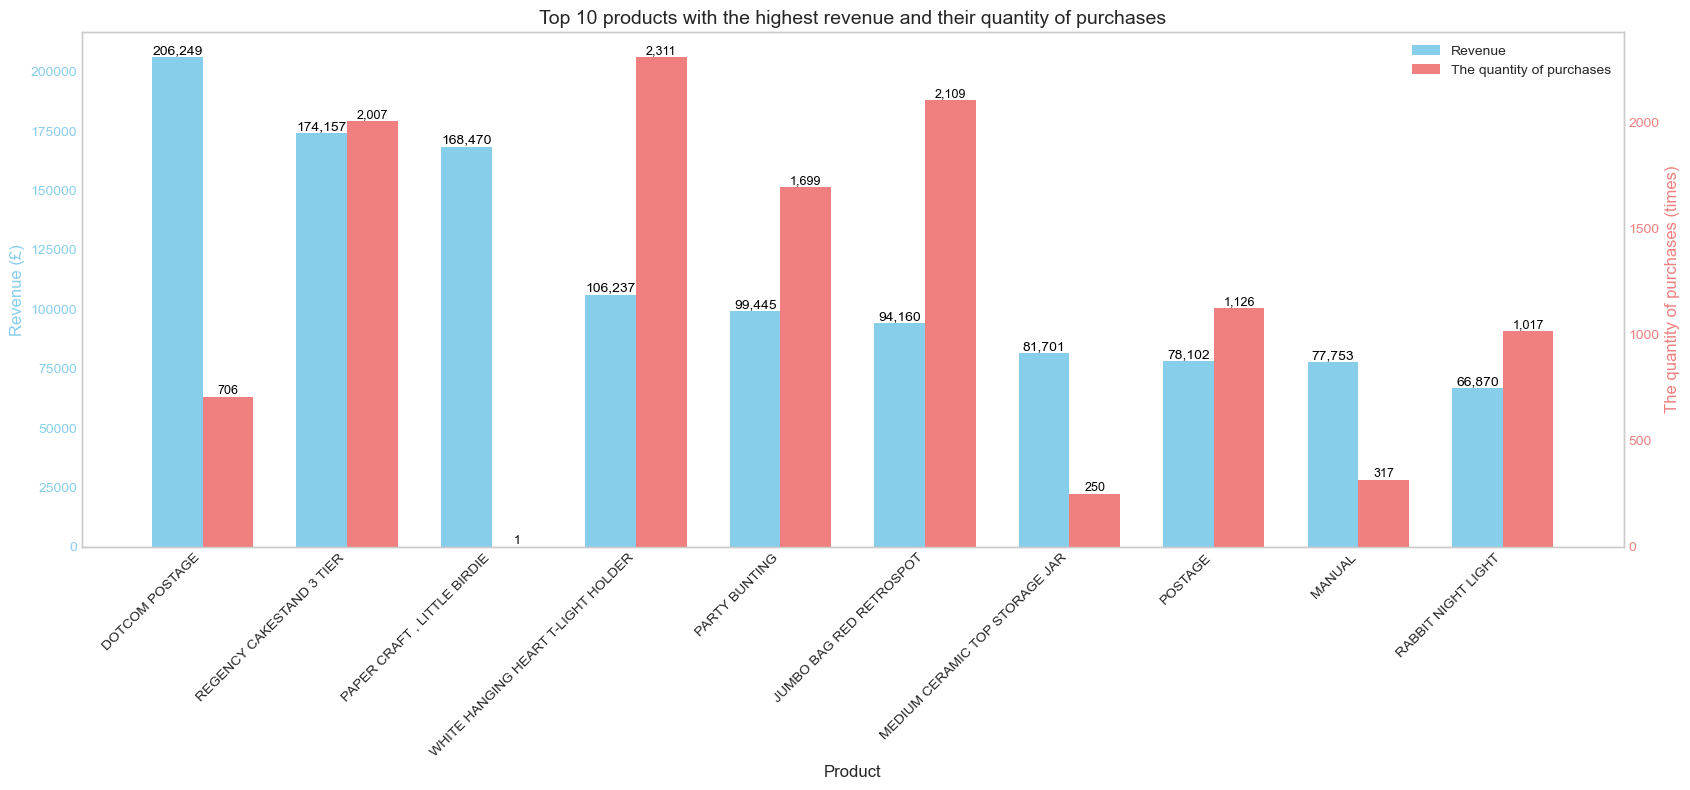

In [8]:
# Counting the number of orders (the number of times each product appears in the Description column)
order_counts = data['Description'].value_counts().reset_index()
order_counts.columns = ['Description', 'OrderCount']

# Calculating the total revenue (TotalPrice) for each product
revenue_by_product = data.groupby('Description')['TotalPrice'].sum().reset_index()

# Counting the number of unique values in the 'Description' column
unique_count = data['Description'].nunique()
print(f"Số lượng các mặt hàng được bán là: {unique_count}")

# Combining revenue and order count data
combined_data = pd.merge(revenue_by_product, order_counts, on='Description')

# Sorting by revenue in descending order and take the top 10 products
top_10_products = combined_data.sort_values(by='TotalPrice', ascending=False).head(10)

# Drawing the combined bar chart
fig, ax1 = plt.subplots(figsize=(17, 8))

# Setting column position
x = np.arange(len(top_10_products))
width = 0.35  # The width of columns

# Drawing a column for revenue (TotalPrice) on the left y-axis
bars1 = ax1.bar(x - width/2, top_10_products['TotalPrice'], width, label='Revenue', color='skyblue')
ax1.set_xlabel('Product', fontsize=12)
ax1.set_ylabel('Revenue (£)', fontsize=12, color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Adding value labels to the revenue column
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', 
             ha='center', va='bottom', fontsize=10, color='black')
    
# Creating a second y-axis for the number of orders
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, top_10_products['OrderCount'], width, label='The quantity of purchases', color='lightcoral')
ax2.set_ylabel('The quantity of purchases (times)', fontsize=12, color='lightcoral')
ax2.tick_params(axis='y', labelcolor='lightcoral')
ax2.grid(False)

# Adding value labels to the order frequency column
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height, f'{height:,.0f}', 
             ha='center', va='bottom', fontsize=9, color='black')
    

# Setting up the title and x-axis label
plt.title('Top 10 products with the highest revenue and their quantity of purchases', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(top_10_products['Description'], rotation=45, ha='right')

# Adding legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
ax1.grid(False)
# Ensuring the neat layout
plt.tight_layout()
plt.show()

In [9]:
# Counting the number of unique CustomerIDs
num_customers = data['CustomerID'].nunique()

# Printing to the screen
print(f"Số lượng các khách hàng tham gia mua hàng là: {num_customers}")

Số lượng các khách hàng tham gia mua hàng là: 4339


10 khách hàng có nhiều lượt mua nhất:


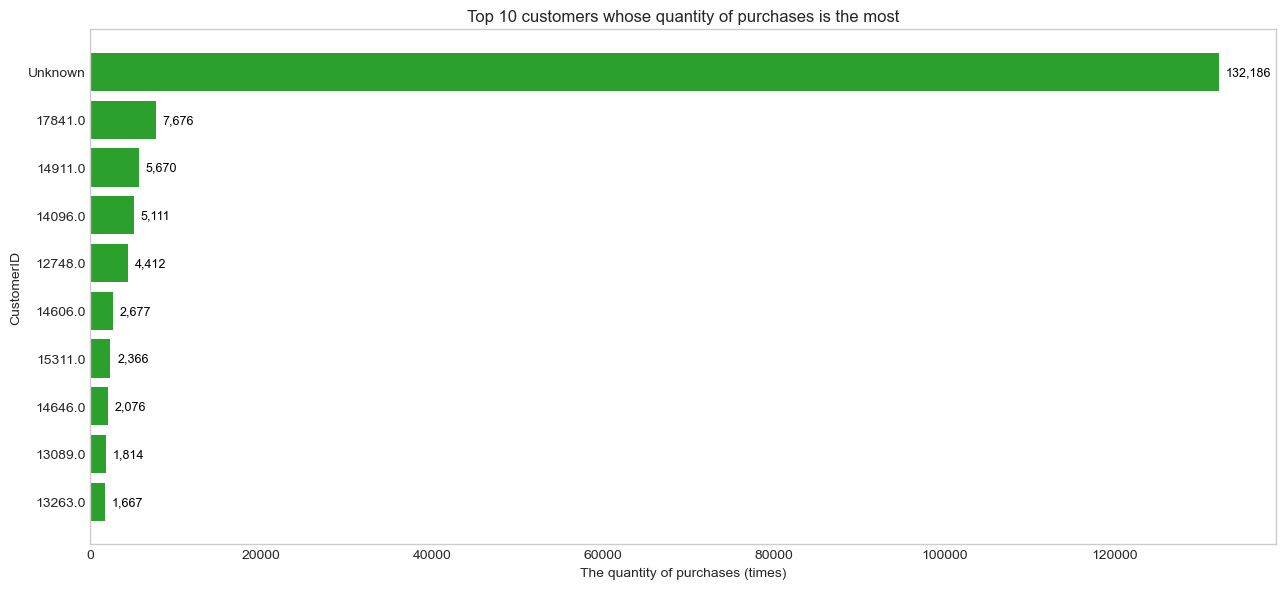

In [10]:
# Counting the number of purchases for each CustomerID and get the top 10
customer_order_count = data['CustomerID'].value_counts().head(10)

# Creating a horizontal bar chart
plt.figure(figsize=(13, 6))
bars = plt.barh(customer_order_count.index.astype(str), customer_order_count.values, color='tab:green')

# Add annotations on each bar showing the purchase count
for bar in bars:
    width = bar.get_width()
    plt.annotate(f'{width:,}',  # Format numbers with comma separators
                 xy=(width, bar.get_y() + bar.get_height() / 2),
                 xytext=(5, 0), textcoords="offset points",
                 ha='left', va='center', fontsize=9, color='black')

# Setting chart title and axis labels
plt.title('Top 10 customers whose quantity of purchases is the most')
plt.xlabel('The quantity of purchases (times)')
plt.ylabel('CustomerID')

# Reversing the y-axis so the customer with the most purchases appears at the top
plt.gca().invert_yaxis()

# Adjusting layout to fit all elements
plt.tight_layout()
plt.grid()
print('10 khách hàng có nhiều lượt mua nhất:')
plt.show()

Số lượng các khách hàng mua sản phẩm 'DOTCOM POSTAGE': 2


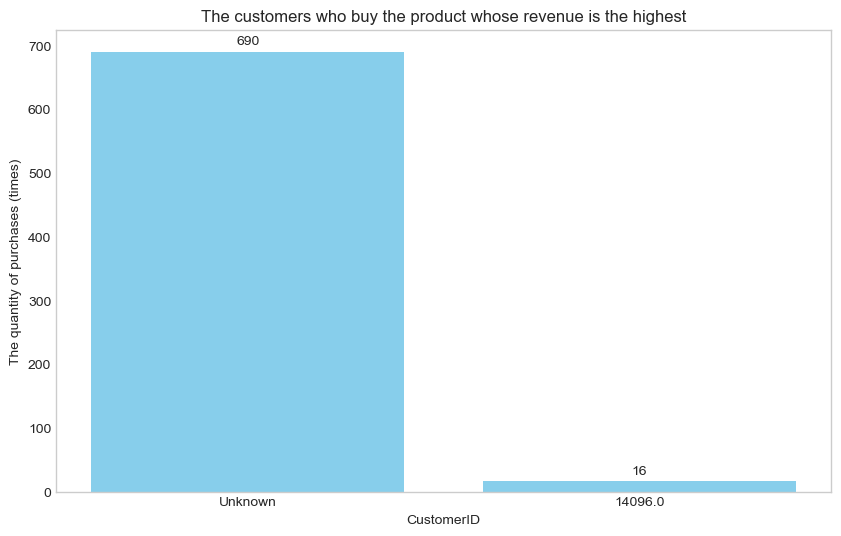

In [11]:
# Filtering the rows where Description is 'DOTCOM POSTAGE'
filtered_df = data[data['Description'] == "DOTCOM POSTAGE"]

# Counting unique CustomerID values
unique_customers = filtered_df['CustomerID'].nunique()
print(f"Số lượng các khách hàng mua sản phẩm 'DOTCOM POSTAGE': {unique_customers}")

# Counting the occurrences of each CustomerID
customer_counts = filtered_df['CustomerID'].value_counts().head(10)

# Plotting a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(customer_counts.index.astype(str), customer_counts.values, color='skyblue')

# Adding values on top of the columns
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # khoảng cách giữa số và cột
                 textcoords="offset points",
                 ha='center', va='bottom')

# Adding title and axis labels
plt.title('The customers who buy the product whose revenue is the highest')
plt.xlabel('CustomerID')
plt.ylabel('The quantity of purchases (times)')
plt.grid(False)
plt.show()

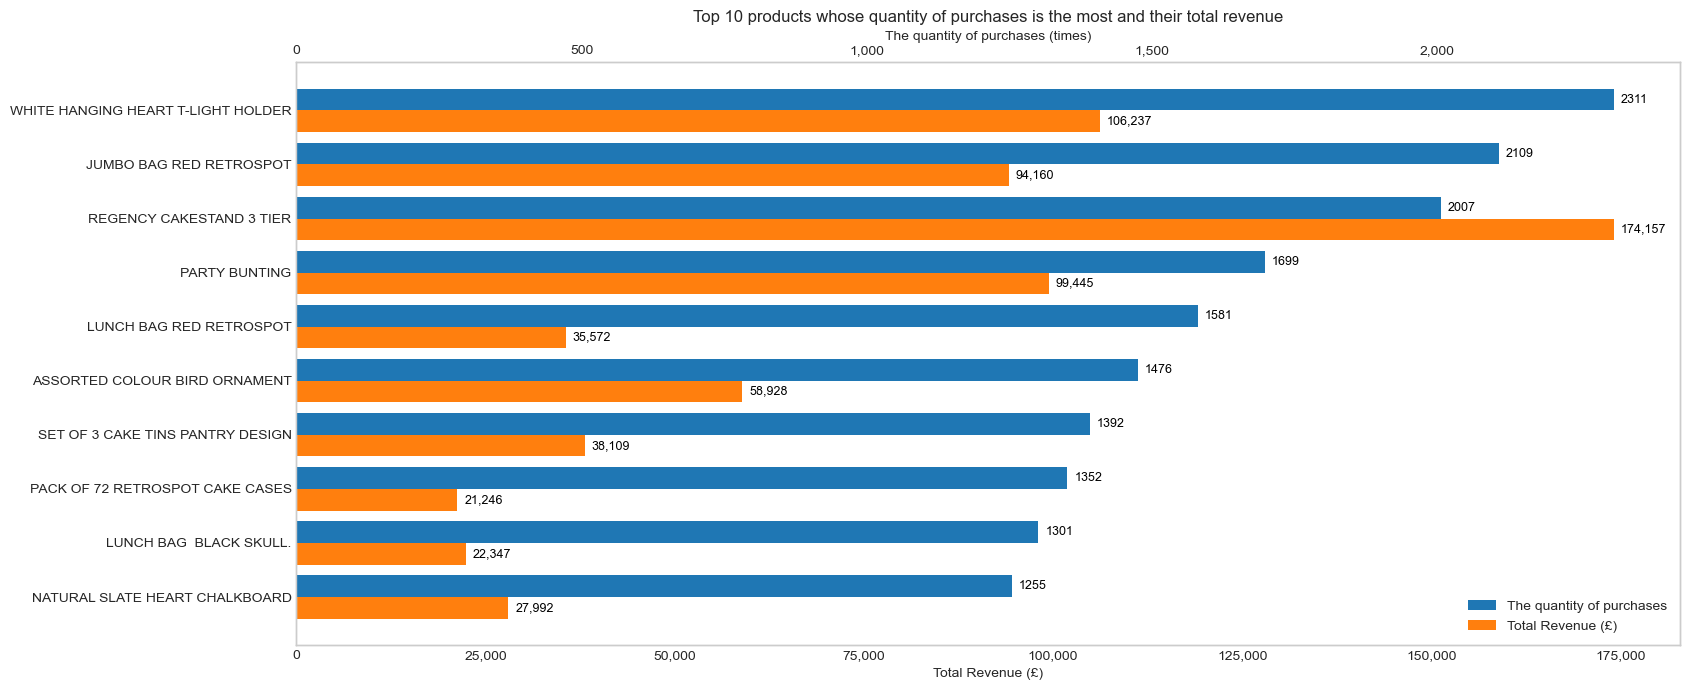

In [12]:
# Grouping by Description to get order count and total revenue
product_stats = data.groupby('Description').agg({
    'InvoiceNo': 'count',       # Number of orders
    'TotalPrice': 'sum'         # Total revenue
}).rename(columns={'InvoiceNo': 'Order Count', 'TotalPrice': 'Total Revenue'})

# Getting top 10 products by number of orders
top_10_products = product_stats.sort_values(by='Order Count', ascending=False).head(10)

# Plotting horizontal bar chart
fig, ax2 = plt.subplots(figsize=(17, 7))  # ax2 will now be the primary axis

bar_width = 0.4
y_positions = range(len(top_10_products))

# Plotting Total Revenue bars (now primary axis)
bars2 = ax2.barh(
    [y + bar_width/2 for y in y_positions], 
    top_10_products['Total Revenue'], 
    height=bar_width, 
    color='tab:orange', 
    label='Total Revenue (£)'
)

# Annotating Total Revenue
for bar in bars2:
    width = bar.get_width()
    ax2.annotate(f'{width:,.0f}', 
                 xy=(width, bar.get_y() + bar.get_height()/2),
                 xytext=(5, 0), textcoords='offset points',
                 ha='left', va='center', fontsize=9, color='black')

# Setting labels and title for ax2 (now primary)
ax2.set_xlabel('Total Revenue (£)')
ax2.set_yticks(y_positions)
ax2.set_yticklabels(top_10_products.index)
ax2.invert_yaxis()  # Largest on top
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
ax2.grid(False)
# Creating secondary axis for Order Count
ax1 = ax2.twiny()

# Plotting Order Count bars (secondary axis)
bars1 = ax1.barh(
    [y - bar_width/2 for y in y_positions], 
    top_10_products['Order Count'], 
    height=bar_width, 
    color='tab:blue', 
    label='The quantity of purchases'
)

# Annotating Order Count
for bar in bars1:
    width = bar.get_width()
    ax1.annotate(f'{width}', 
                 xy=(width, bar.get_y() + bar.get_height()/2),
                 xytext=(5, 0), textcoords='offset points',
                 ha='left', va='center', fontsize=9, color='black')

# Setting labels for ax1 (now secondary)
ax1.set_xlabel('The quantity of purchases (times)')
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

# Adding title and legends
plt.title('Top 10 products whose quantity of purchases is the most and their total revenue')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')
ax1.grid(False)
plt.tight_layout()
plt.show()

Số lượng khách hàng mua sản phẩm 'WHITE HANGING HEART T-LIGHT HOLDER': 857


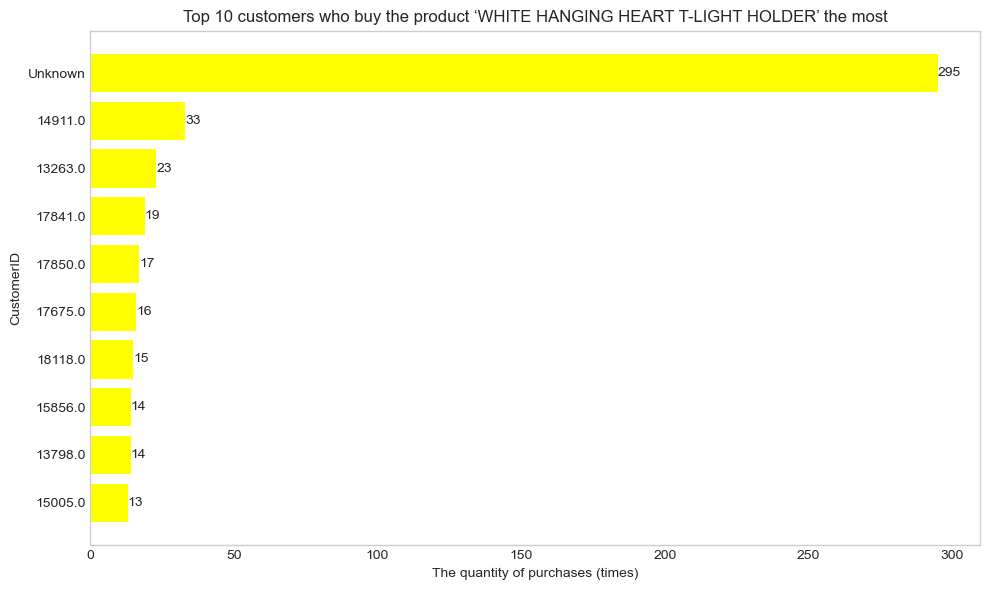

In [13]:
# Filtering rows whose value in the column 'Description' is 'WHITE HANGING HEART T-LIGHT HOLDER'
filtered= data[data['Description'] == 'WHITE HANGING HEART T-LIGHT HOLDER']

# Counting unique CustomerID values
unique_customer_ids = filtered['CustomerID'].nunique(dropna=True)
print(f"Số lượng khách hàng mua sản phẩm 'WHITE HANGING HEART T-LIGHT HOLDER': {unique_customer_ids}")

# Counting the number of occurrences of each CustomerID
customer_counts = filtered['CustomerID'].value_counts().head(10)

# Plotting a horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(customer_counts.index.astype(str), customer_counts.values, color='yellow')

# Adding data labels to each bar"
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{int(bar.get_width())}', va='center')

plt.xlabel('The quantity of purchases (times)')
plt.ylabel('CustomerID')
plt.title('Top 10 customers who buy the product ‘WHITE HANGING HEART T-LIGHT HOLDER’ the most')
plt.gca().invert_yaxis()  # Đảo ngược trục y để giá trị lớn nhất ở trên
plt.tight_layout()
plt.grid(False)
plt.show()

Số lượng các khách hàng là:  4339
Số lượng các khách có mã CustomerID là: 4338


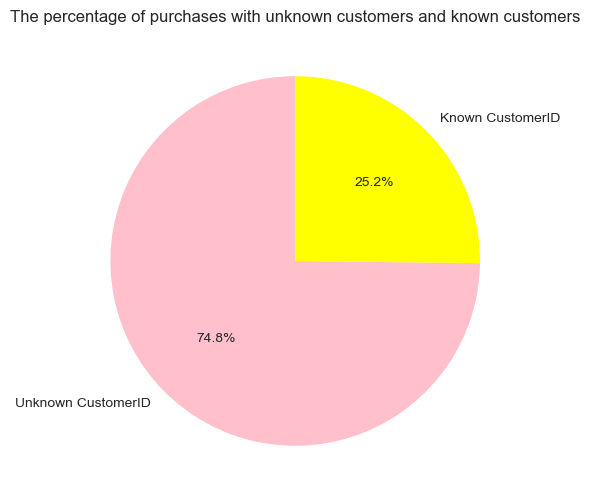

In [14]:
# Counting the number of unique CustomerID values
unique_customer_ids = data['CustomerID'].nunique()

# Printing results
print("Số lượng các khách hàng là: ", unique_customer_ids)

# Filtering the rows whose the column 'CustomerID' is not 'Unknown'
filtered = data[data['CustomerID'] != 'Unknown']

# Counting the number of unique CustomerID values
Unique_customer_ids = filtered['CustomerID'].nunique()

# Printing results
print("Số lượng các khách có mã CustomerID là:", Unique_customer_ids)

# Counting the number of rows whose CustomerID is 'unknown' and not 'unknown'
counts = data['CustomerID'].apply(lambda x: x == "Unknown").value_counts()

# Setting the label name
labels = ['Unknown CustomerID', 'Known CustomerID']

# Drawing the pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['pink','yellow'])
plt.title('The percentage of purchases with unknown customers and known customers')
plt.show()

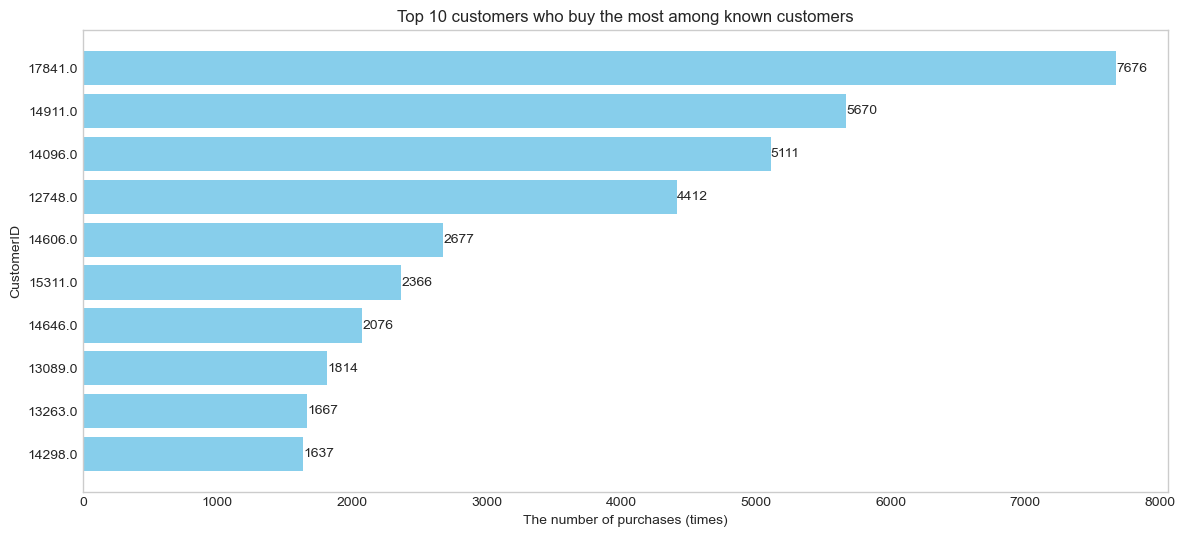

In [15]:
# Filtering out the rows whose CustomerID is ‘unknown’
data_filtered = data[data['CustomerID'] != "Unknown"]

# Counting the number of occurrences of each CustomerID
top_10_customers = data_filtered['CustomerID'].value_counts().head(10)

# Drawing the horizontal bar chart
plt.figure(figsize=(14, 6))
bars = plt.barh(top_10_customers.index, top_10_customers.values, color='skyblue')

# Adding data labels to each bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, str(int(width)), va='center')

# Setting title and labels
plt.xlabel('The number of purchases (times)')
plt.ylabel('CustomerID')
plt.title('Top 10 customers who buy the most among known customers')
plt.gca().invert_yaxis()  # Inverting the Y-axis so that the largest value is at the top
plt.grid(False)
plt.show()

Số lượng các loại hàng mà khách hàng có ID '17841' hay mua là: 1343


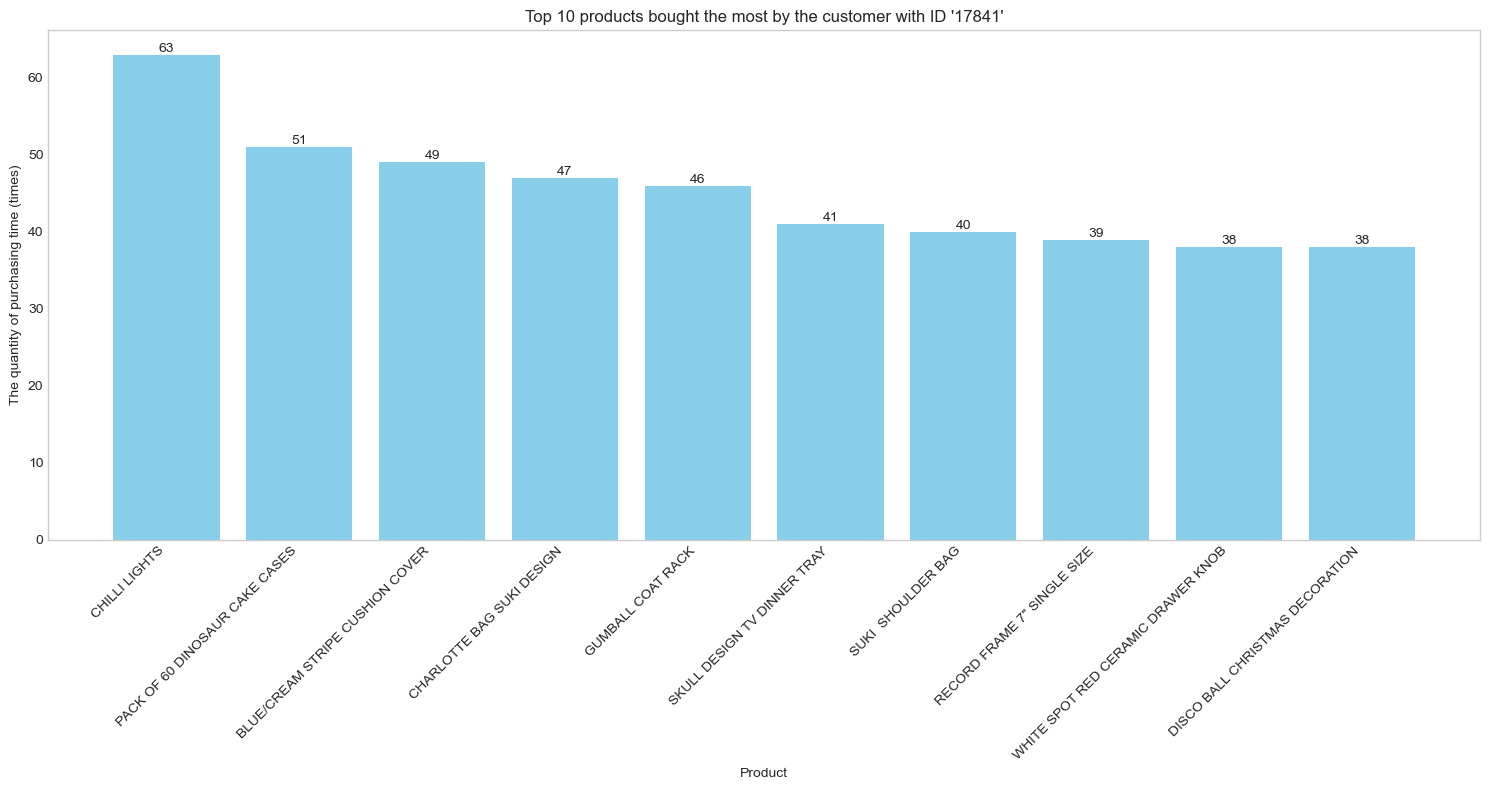

In [17]:
# Filtering rows where CustomerID is 17841
filtered_data = data[data['CustomerID'] == '17841']

# Converting CustomerID to string because its data type is float
data['CustomerID'] = data['CustomerID'].astype(str).str.strip('.0')

# Counting the number of unique values in the Description column
unique_descriptions_count = filtered_data['Description'].nunique()
print("Số lượng các loại hàng mà khách hàng có ID '17841' hay mua là:", unique_descriptions_count)

# Counting the occurrences of the Description values
description_counts = filtered_data['Description'].value_counts().nlargest(10)

# Drawing the bar chart
plt.figure(figsize=(15, 8))
bars = plt.bar(description_counts.index, description_counts.values, color='skyblue')

# Adding figures on each column
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, int(height), ha='center', va='bottom')

plt.title("Top 10 products bought the most by the customer with ID '17841'")
plt.xlabel('Product')
plt.ylabel('The quantity of purchasing time (times)')
plt.grid()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Analysis by time factors

Số lượng các năm có lượt mua hàng là:  2
Các năm có lượt mua hàng là:  [2010 2011]


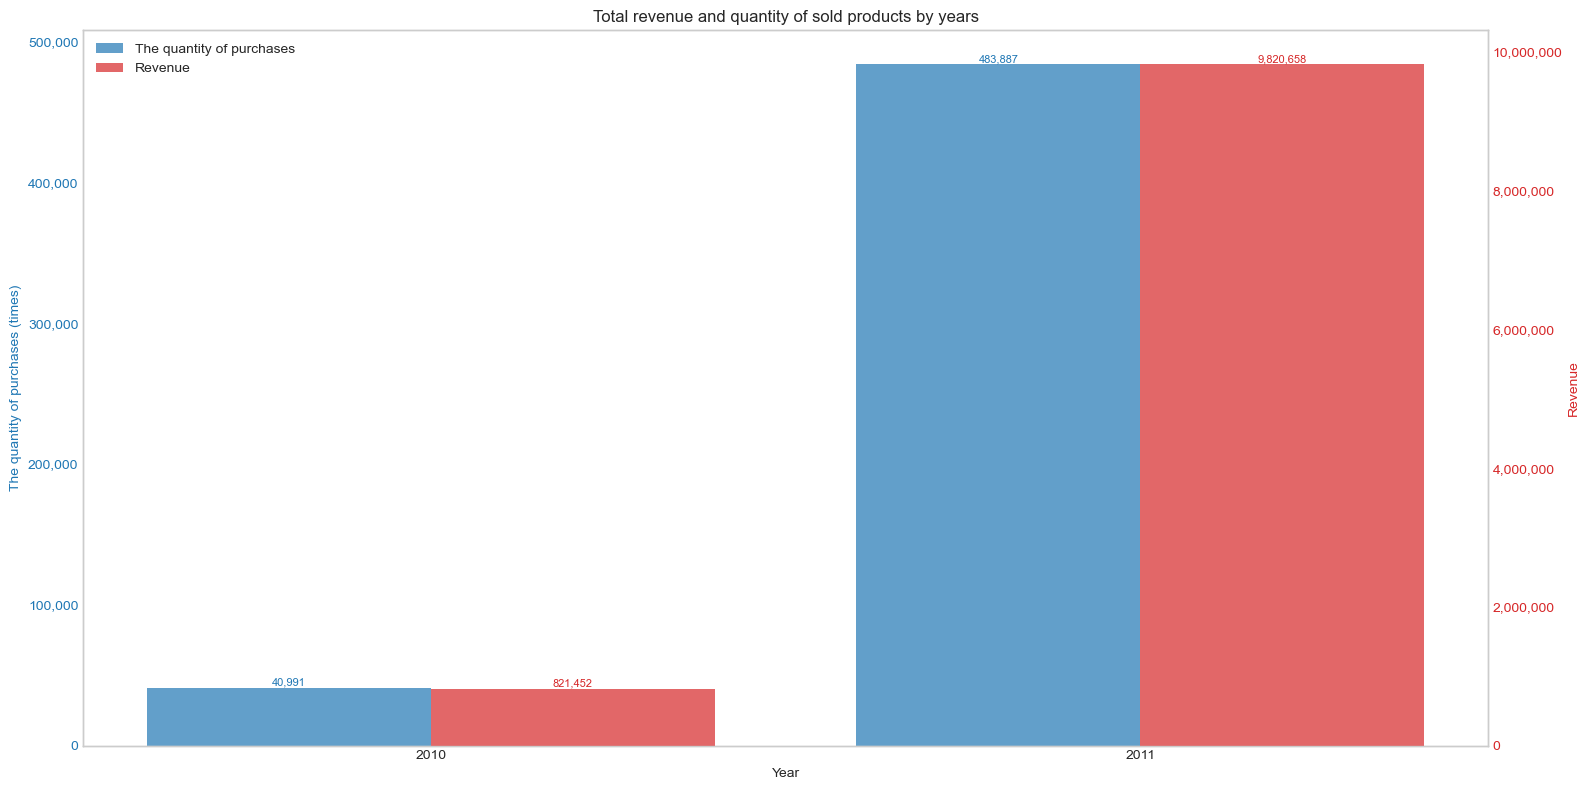

In [18]:
# Counting the number of unique CustomerID values
unique_year= data['InvoiceYear'].nunique()

# Printing results
print("Số lượng các năm có lượt mua hàng là: ", unique_year)
print("Các năm có lượt mua hàng là: ", data['InvoiceYear'].unique())
# Calculating total revenue and number of orders by year
summary = df.groupby('InvoiceYear').agg(
    TotalRevenue=('TotalPrice', 'sum'),
    OrderCount=('InvoiceNo', 'count')
).reset_index()

# Plotting a chart
fig, ax1 = plt.subplots(figsize=(16, 8))

# Column - Number of Orders (left axis)
bars1 = ax1.bar(summary['InvoiceYear'] - 0.2, summary['OrderCount'], width=0.4,
                label='The quantity of purchases', color='tab:blue', alpha=0.7)
ax1.set_xlabel('Year')
ax1.set_ylabel('The quantity of purchases (times)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Formatting the left vertical axis
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# The horizontal axis only displays 2010 and 2011
ax1.set_xticks([2010, 2011])
ax1.set_xticklabels([2010, 2011])

# Second axis – Total Revenue (right axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(summary['InvoiceYear'] + 0.2, summary['TotalRevenue'], width=0.4,
                label='Revenue', color='tab:red', alpha=0.7)
ax2.set_ylabel('Revenue', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Formatting the right y-axis (with thousand separators)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Adding data labels on the columns
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', ha='center', va='bottom', fontsize=8, color='tab:blue')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}', ha='center', va='bottom', fontsize=8, color='tab:red')

# Title and caption
plt.title('Total revenue and quantity of sold products by years')
ax2.grid()

# Showing
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.grid()
plt.tight_layout()
plt.show()

Số lượng các mặt hàng được mua qua các năm:


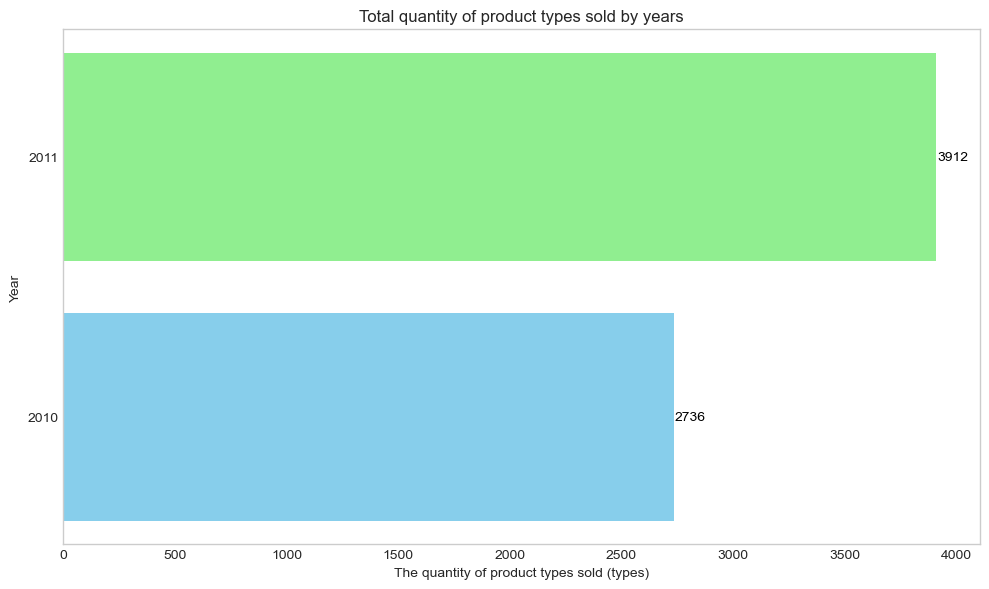

In [19]:
# Grouping the data to get the number of unique Descriptions by year
unique_products = data.groupby('InvoiceYear')['Description'].nunique()

# Drawing a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(unique_products.index.astype(str), unique_products.values, color=['skyblue', 'lightgreen'])

# Adding data labels on each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 5, bar.get_y() + bar.get_height() / 2,
            str(width),
            va='center', ha='left', fontsize=10, color='black')

# Setting title and labels
ax.set_xlabel('The quantity of product types sold (types)')
ax.set_ylabel('Year')
ax.set_title('Total quantity of product types sold by years')
ax.grid(False)
print('Số lượng các mặt hàng được mua qua các năm:')
plt.tight_layout()
plt.show()

Số lượng các lượt mua hàng qua các tháng của các năm:


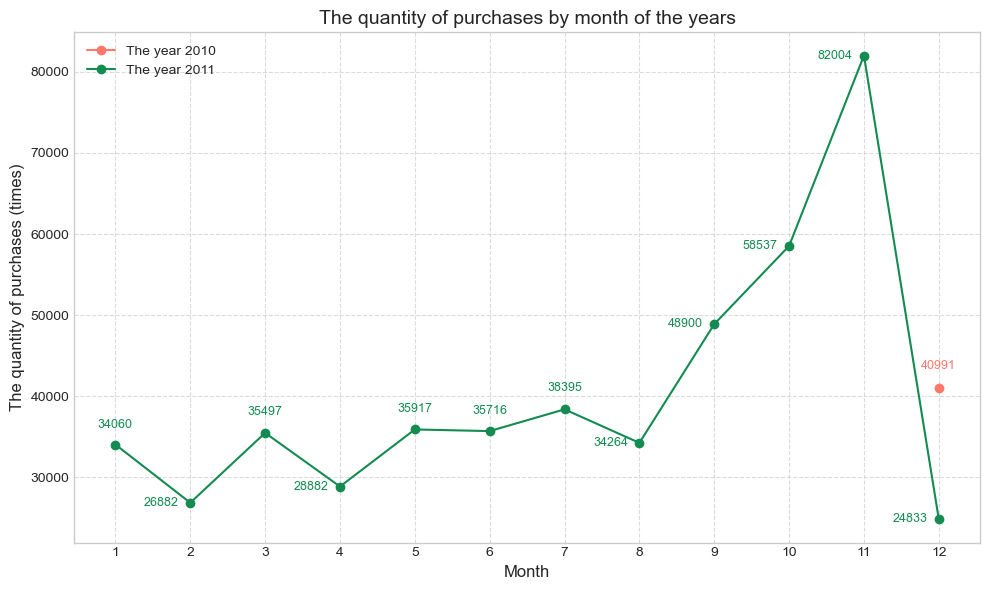

In [20]:
order_counts = data.groupby(['InvoiceYear', 'InvoiceMonth']).size().reset_index(name='OrderCount')

# Plotting the chart
plt.figure(figsize=(10, 6))
colors = {2010: "#FF7869", 2011: "#138B51"}  

# Formatting the right y-axis (with comma as thousand separator)
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
for year in data['InvoiceYear'].unique():
    year_data = order_counts[order_counts['InvoiceYear'] == year]
    plt.plot(year_data['InvoiceMonth'], year_data['OrderCount'], marker='o', color=colors[year], label=f'The year {year}')
    # Caption
    for x, y in zip(year_data['InvoiceMonth'], year_data['OrderCount']):
        # Condition to shift left
        if year == 2011 and x in [2, 4, 8, 9, 10, 12]:
            plt.text(x - 0.15, y, str(y), ha='right', va='center', fontsize=9, color=colors[year])
        elif year == 2011 and x == 11:
            plt.text(x - 0.15, y, str(y), ha='right', va='center', fontsize=9, color=colors[year])
        else:
            plt.text(x, y * 1.05, str(y), ha='center', va='bottom', fontsize=9, color=colors[year])

print("Số lượng các lượt mua hàng qua các tháng của các năm:")
plt.title('The quantity of purchases by month of the years', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('The quantity of purchases (times)', fontsize=12)
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Doanh thu các tháng năm 2011:


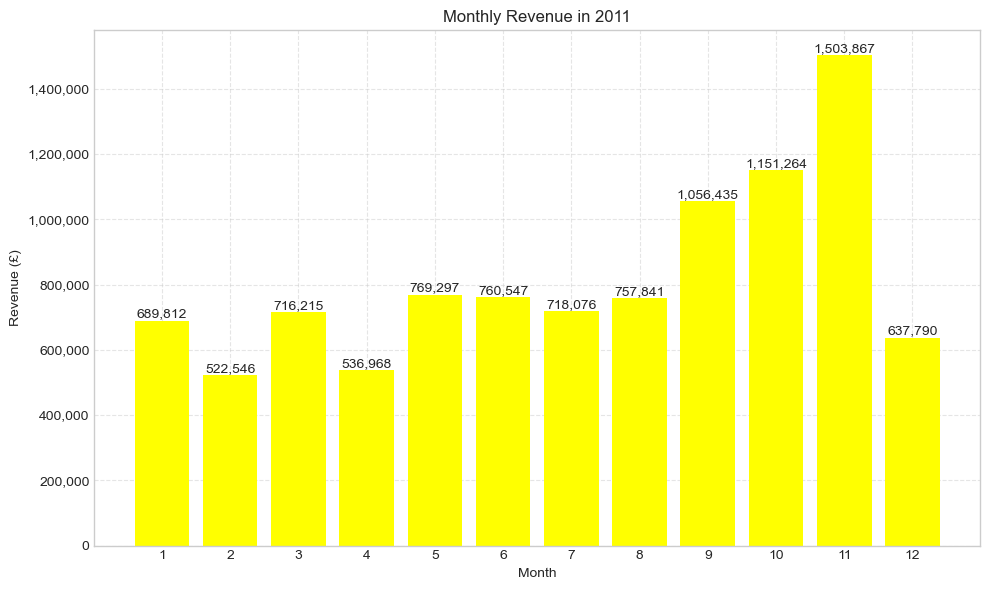

In [21]:
# Filtering data for the year 2011
data_2011 = data[data['InvoiceYear'] == 2011]

# Calculating the total revenue for each month
monthly_revenue = data_2011.groupby('InvoiceMonth')['TotalPrice'].sum()

# Ensuring all 12 months are present (if any month is missing, set its revenue to 0)
monthly_revenue = monthly_revenue.reindex(range(1, 13), fill_value=0)

# Plotting a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_revenue.index, monthly_revenue.values, color='yellow')

# Adding data labels on each column
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=10)

# Formating y-axis to avoid scientific notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

print('Doanh thu các tháng năm 2011:')
# Setting title and labels
plt.title('Monthly Revenue in 2011')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.xticks(range(1, 13), [f'{m}' for m in range(1, 13)])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
# Displaying the chart
plt.tight_layout()
plt.show()

- Số lượng các mặt hàng bán được trong tháng 11, năm 2011 là: 2914 mặt hàng
- Số lượng các lượt mua hàng theo các ngày trong tuần của tháng 11 năm 2011:


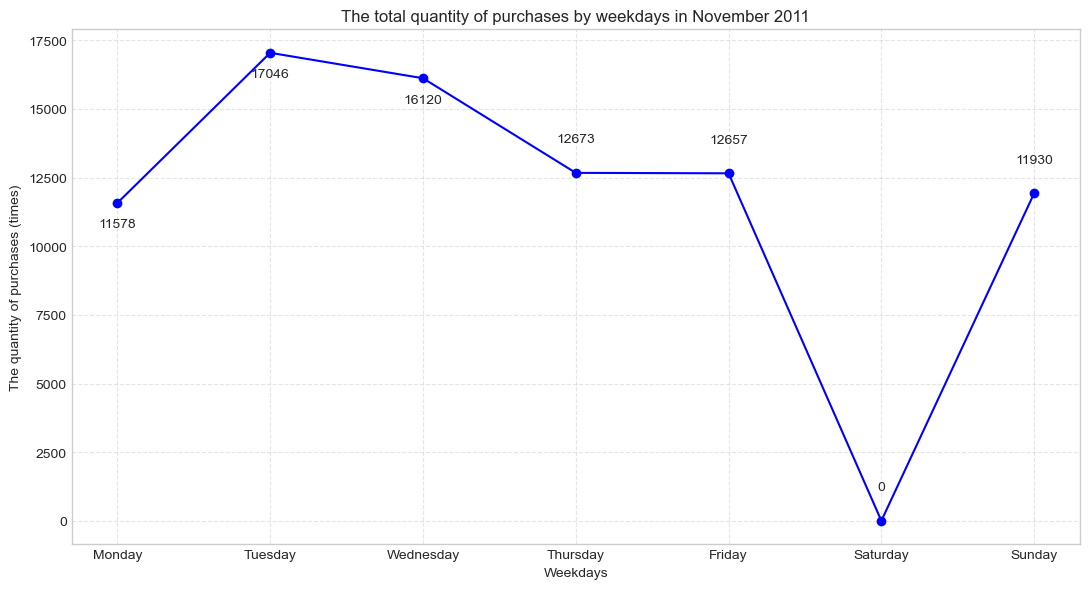

In [22]:
# Filtering data for InvoiceYear = 2011 and InvoiceMonth = 11
filtered_data = data[(data['InvoiceYear'] == 2011) & (data['InvoiceMonth'] == 11)]

# Counting the number of unique Weekday values
weekday_counts = filtered_data['InvoiceWeekday'].value_counts()

# Ensure the x-axis includes all 7 days from Monday to Sunday
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(ordered_days, fill_value=0)

# Counting the number of unique Description values
unique_descriptions_count = filtered_data['Description'].nunique()

# Printing the result to the screen
print("- Số lượng các mặt hàng bán được trong tháng 11, năm 2011 là:", unique_descriptions_count, "mặt hàng")

# Drawing a line chart
plt.figure(figsize=(11, 6))
plt.plot(weekday_counts.index, weekday_counts.values, marker='o', linestyle='-', color='b')

# Adding data annotations on each point with position adjustment
for day, count in zip(weekday_counts.index, weekday_counts.values):
    # Adjusting positions
    if day in ['Thursday', 'Friday', 'Saturday', 'Sunday']:
        y_offset = 1000 
    elif day in ['Monday', 'Tuesday', 'Wednesday']:
        y_offset = -1000 
    else:
        y_offset = 0  

    plt.text(day, count + y_offset, str(int(count)), ha='center', va='bottom', fontsize=10)

# Setting title and labels
plt.title('The total quantity of purchases by weekdays in November 2011')
plt.xlabel('Weekdays')
plt.ylabel('The quantity of purchases (times)')
plt.xticks(ordered_days)  # Ensuring the x-axis is in the correct order
plt.grid(True, linestyle='--', alpha=0.5)

print("- Số lượng các lượt mua hàng theo các ngày trong tuần của tháng 11 năm 2011:")
# Displaying the chart
plt.tight_layout()
plt.show()

In [23]:
# Filtering for InvoiceMonth = 11 and InvoiceYear = 2011
november_2011 = data[(data['InvoiceMonth'] == 11) & (data['InvoiceYear'] == 2011)]

# Counting unique InvoiceDay values
unique_days_count = november_2011['InvoiceDay'].nunique()

# Printing the result
print(f"Số lượng các ngày có lượt mua hàng trong tháng 11, năm 2011: {unique_days_count}")

Số lượng các ngày có lượt mua hàng trong tháng 11, năm 2011: 26


In [24]:
# Getting unique InvoiceDay values and sort them
unique_days = sorted(november_2011['InvoiceDay'].unique())
print(f"Các ngày có lượt mua hàng trong tháng 11, năm 2011: {unique_days}")

Các ngày có lượt mua hàng trong tháng 11, năm 2011: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30]


C:\Users\levuo\AppData\Local\Temp\ipykernel_3284\4291697858.py:28: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(False, linestyle='--', alpha=0.5)


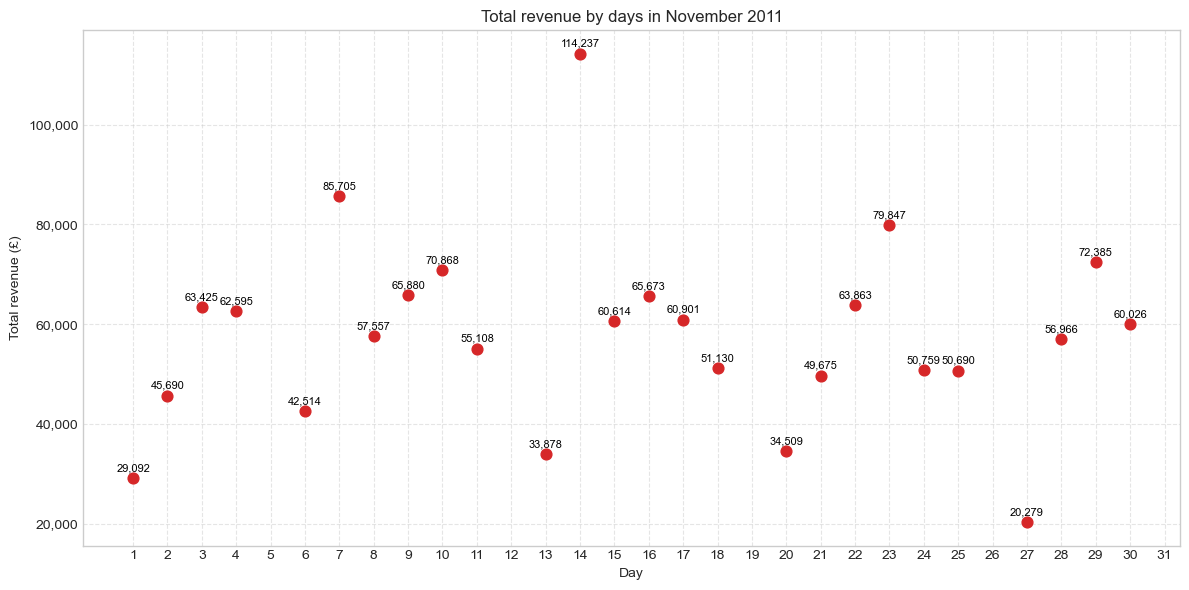

In [25]:
# Filtering data for November 2011
nov_2011 = data[(data['InvoiceMonth'] == 11) & (data['InvoiceYear'] == 2011)]

# Grouping by InvoiceDay and calculate total revenue
daily_revenue = nov_2011.groupby('InvoiceDay')['TotalPrice'].sum().sort_index()

# Plotting scatter chart
plt.figure(figsize=(12, 6))
plt.scatter(daily_revenue.index, daily_revenue.values, color='tab:red', s=60)

# Annotating each point with total revenue
for day, revenue in daily_revenue.items():
    plt.annotate(f'{revenue:,.0f}',
                 (day, revenue),
                 textcoords="offset points",
                 xytext=(0, 5),
                 ha='center', fontsize=8, color='black')


# Formating y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Setting chart title and labels
plt.title('Total revenue by days in November 2011')
plt.xlabel('Day')
plt.ylabel('Total revenue (£)')
plt.xticks(range(1, 32))  # Days 1 to 31
plt.grid(False, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [26]:
# Filtering data for 14 November 2011
day_14_nov_2011 = data[
    (data['InvoiceDay'] == 14) &
    (data['InvoiceMonth'] == 11) &
    (data['InvoiceYear'] == 2011)
]

# Getting unique InvoiceHour values and sort them
unique_hours = sorted(day_14_nov_2011['InvoiceHour'].unique())

# Counting the number of unique hours
unique_hours_count = len(unique_hours)

# Printing the results
print(f"Số lượng các khung giờ có lượt mua hàng trong ngày 14 tháng 11 năm 2011 là: {unique_hours_count}")


Số lượng các khung giờ có lượt mua hàng trong ngày 14 tháng 11 năm 2011 là: 10


In [27]:
# Getting unique InvoiceHour values and sort them
unique_hours = sorted(day_14_nov_2011['InvoiceHour'].unique())
print(f"Các khung giờ có lượt mua hàng trong ngày 14 tháng 11 năm 2011 là: {unique_hours}")

Các khung giờ có lượt mua hàng trong ngày 14 tháng 11 năm 2011 là: [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


Số lượng các lượt mua hàng theo các giờ trong ngày 14 tháng 11 năm 2011:


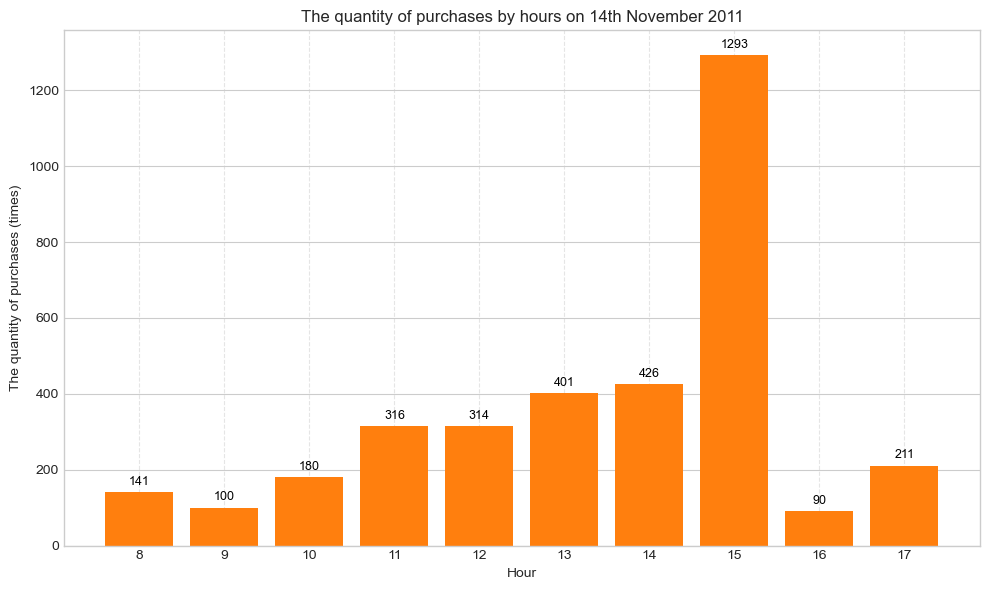

In [28]:
# Filtering data for 14 November 2011
day_14_nov_2011 = data[
    (data['InvoiceDay'] == 14) &
    (data['InvoiceMonth'] == 11) &
    (data['InvoiceYear'] == 2011)
]

# Filtering only for the specified hours
selected_hours = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
hourly_order_count = (
    day_14_nov_2011[day_14_nov_2011['InvoiceHour'].isin(selected_hours)]
    ['InvoiceHour']
    .value_counts()
    .reindex(selected_hours, fill_value=0)
)

# Plotting bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(hourly_order_count.index, hourly_order_count.values, color='tab:orange')

# Annotating number of orders on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # Slight offset above bar
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=9, color='black')

# Setting chart title and labels
plt.title('The quantity of purchases by hours on 14th November 2011')
plt.xlabel("Hour")
plt.ylabel('The quantity of purchases (times)')
plt.xticks(selected_hours)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
print(f"Số lượng các lượt mua hàng theo các giờ trong ngày 14 tháng 11 năm 2011:")
plt.show()

** Số lượng các lượt mua hàng theo mùa của các năm**
 
   Season   2010    2011
0  Autumn      0  121559
1  Spring      0   96439
2  Summer      0  100515
3  Winter  40991  165374
4   Total  40991  483887
 
**Tỉ lệ phần trăm tổng số lượng các lượt mua hàng theo mùa của các năm**
 


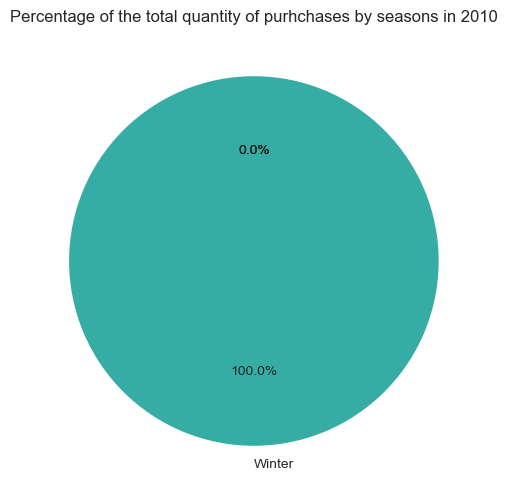

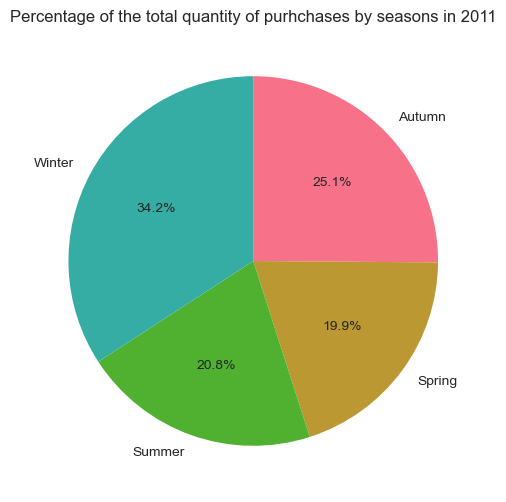

In [29]:
# Grouping by Season and Year, count occurrences
season_year_counts = data.groupby(['Season', 'InvoiceYear']).size().unstack(fill_value=0)

# Renaming columns for clarity
season_year_counts.columns = ['2010', '2011']

# Adding a Total row
season_year_counts.loc['Total'] = season_year_counts.sum()

# Resetting index to have Season as a column
summary_table = season_year_counts.reset_index()

# Printing the 5-row, 3-column table
print("** Số lượng các lượt mua hàng theo mùa của các năm**")
print(' ')
print(summary_table)
print(' ')

# Counting the number of unique Season values for each InvoiceYear
season_counts = data.groupby('InvoiceYear')['Season'].value_counts().unstack(fill_value=0)

print("**Tỉ lệ phần trăm tổng số lượng các lượt mua hàng theo mùa của các năm**")
print(' ')
# Drawing the pie chart for each InvoiceYear
for year in season_counts.index:
    plt.figure(figsize=(6, 6))
    season_counts.loc[year].plot(kind='pie', autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title(f'Percentage of the total quantity of purhchases by seasons in {year}')
    plt.ylabel('')  
    plt.show()
    
    
    

## Analysis results by countries


- Các đơn hàng đến từ 38 quốc gia
- Top 10 quốc gia có doanh thu cao nhất và số lượng đơn hàng bán được tương ứng:


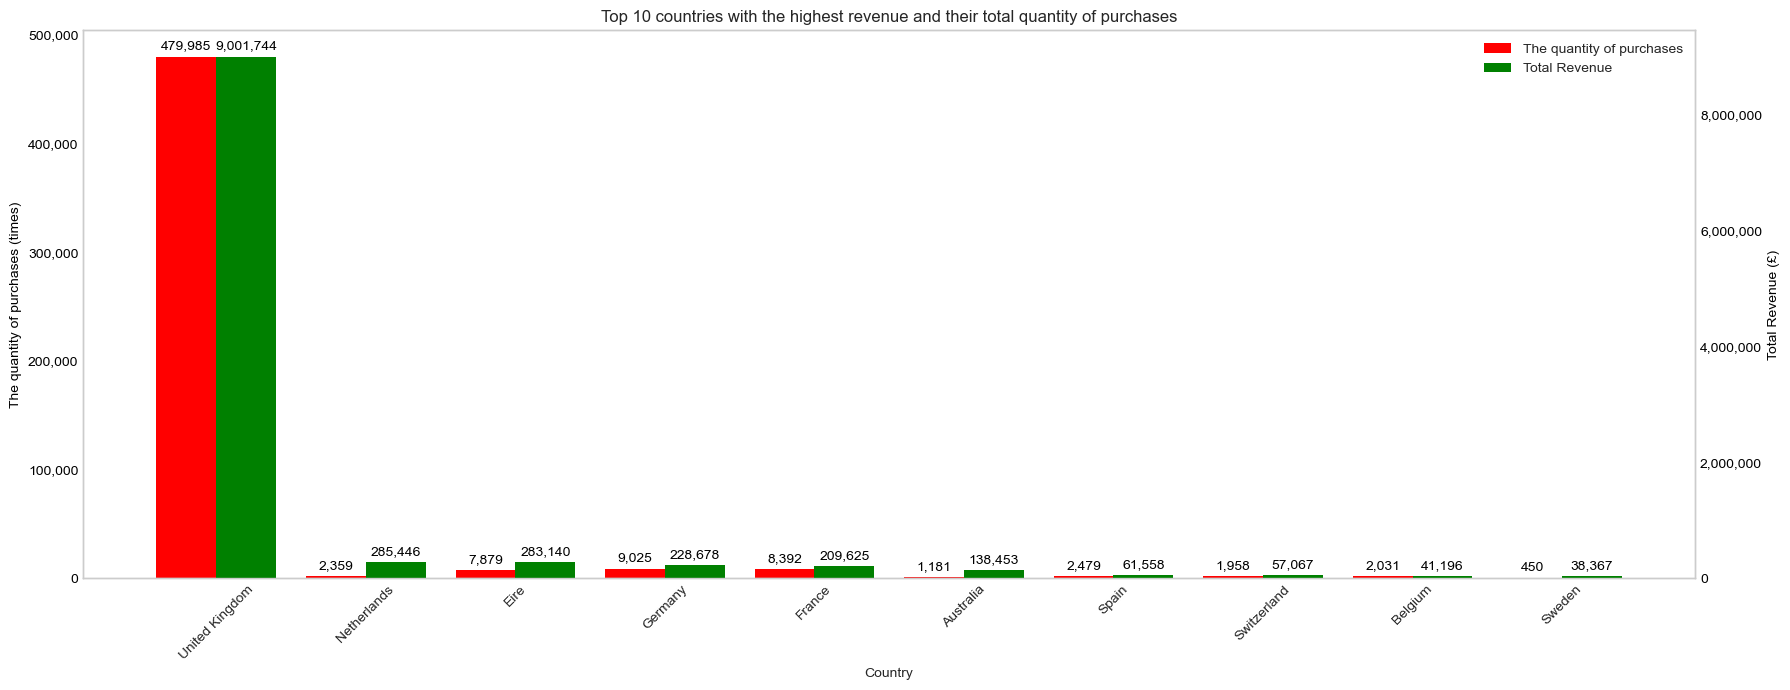

In [30]:
 # Counting the number of unique Country values
num_countries = data['Country'].nunique()

# Printing to screen
print(f"- Các đơn hàng đến từ {num_countries} quốc gia")

 # Counting the number of orders (occurrences) for each country
order_counts = data['Country'].value_counts()

# Calculating the total revenue (TotalPrice) for each country
total_revenue = df.groupby('Country')['TotalPrice'].sum()

# Getting the top 10 countries with the highest total revenue
top_countries = total_revenue.sort_values(ascending=False).head(10).index

# Creating a combined DataFrame
summary = pd.DataFrame({
    'OrderCount': order_counts[top_countries],
    'TotalRevenue': total_revenue[top_countries]
}).reset_index().rename(columns={'index': 'Country'})

# Drawing a chart with two distinct y-axes
fig, ax1 = plt.subplots(figsize=(18, 7))

bar_width = 0.4
x = range(len(summary))

# Adding data labels for Order Count
bars1 = ax1.bar([i - bar_width/2 for i in x], summary['OrderCount'], width=bar_width, label='The quantity of purchases', color='red')
ax1.set_ylabel('The quantity of purchases (times)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Định dạng số nguyên có dấu phẩy

# Adding data labels for Order Count
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{int(height):,}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', color='black')

# Creating a second y-axis on the right for Total Revenue
ax2 = ax1.twinx()
bars2 = ax2.bar([i + bar_width/2 for i in x], summary['TotalRevenue'], width=bar_width, label='Total Revenue', color='green')
ax2.set_ylabel('Total Revenue (£)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Định dạng số nguyên có dấu phẩy

# Adding data labels for Total Revenue
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{int(height):,}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', color='black')
# Adding a legend for both axes
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(handles, labels, loc='upper right')

# Setting title and axis labels
ax1.set_xlabel('Country')
ax1.set_title('Top 10 countries with the highest revenue and their total quantity of purchases')
ax1.set_xticks(x)
ax1.set_xticklabels(summary['Country'], rotation=45)
ax1.grid()

fig.tight_layout()
plt.grid()
print('- Top 10 quốc gia có doanh thu cao nhất và số lượng đơn hàng bán được tương ứng:')
plt.show()

Top 10 quốc gia có số lượng đơn hàng bán được nhiều nhất và doanh thu tương ứng:


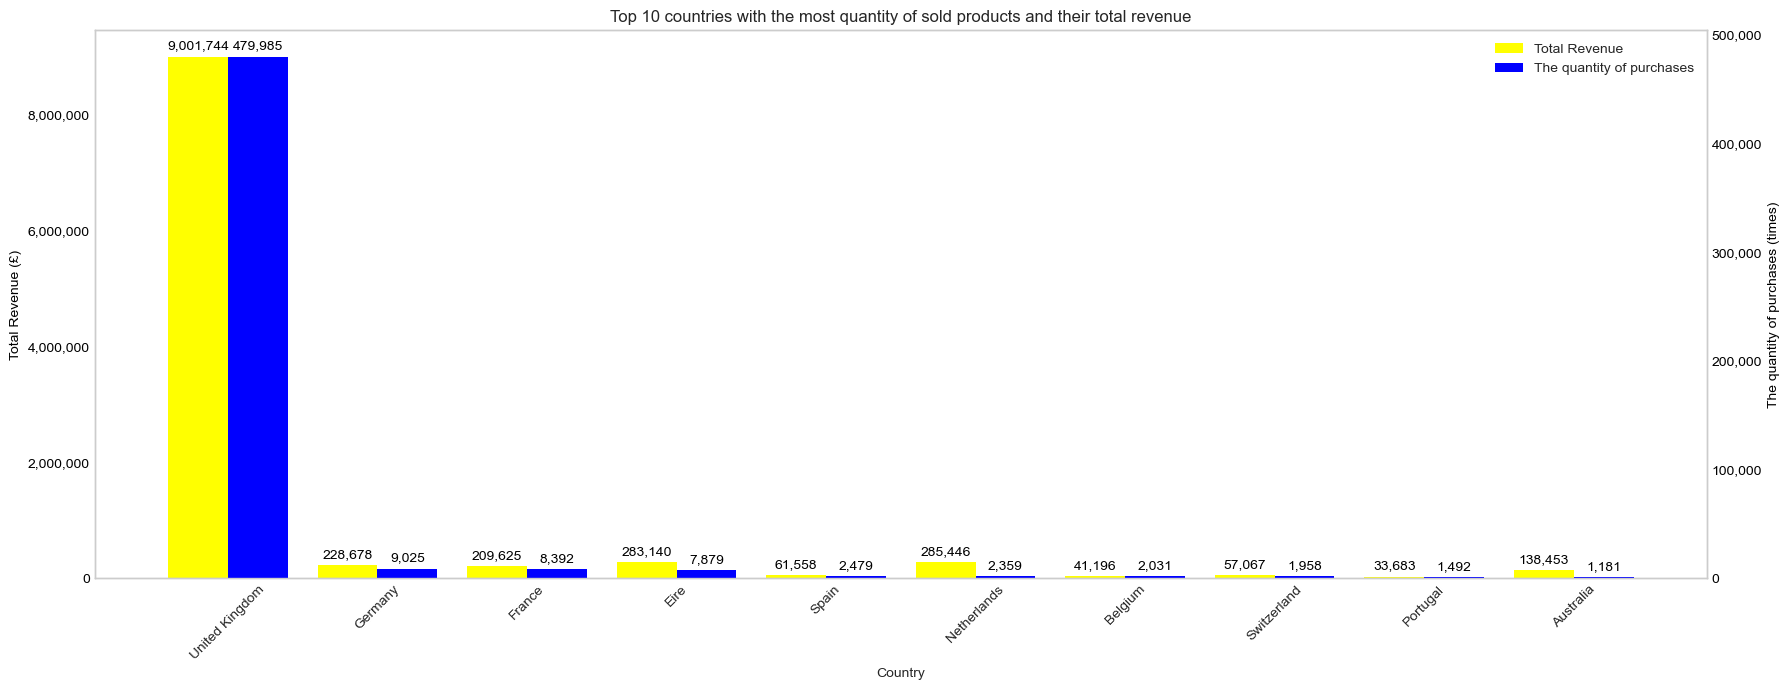

In [31]:
# Counting the number of orders (occurrences) for each country
order_counts = data['Country'].value_counts()

# Calculating the total revenue (TotalPrice) for each country
total_revenue = df.groupby('Country')['TotalPrice'].sum()

# Getting the top 10 countries with the highest total revenue
top_countries = order_counts.sort_values(ascending=False).head(10).index

# Creating a combined DataFrame
summary = pd.DataFrame({
    'OrderCount': order_counts[top_countries],
    'TotalRevenue': total_revenue[top_countries]
}).reset_index().rename(columns={'index': 'Country'})

# Plotting a chart with two separate y-axes
fig, ax1 = plt.subplots(figsize=(18, 7))

bar_width = 0.4
x = range(len(summary))

# Plotting the number of orders on the left y-axis
bars1 = ax1.bar([i - bar_width/2 for i in x], summary['TotalRevenue'], width=bar_width, label='Total Revenue', color='yellow')
ax1.set_ylabel('Total Revenue (£)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Định dạng số nguyên có dấu phẩy

# Adding data labels for Order Count
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{int(height):,}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', color='black')

# Creating a second y-axis on the right for Total Revenue
ax2 = ax1.twinx()
bars2 = ax2.bar([i + bar_width/2 for i in x], summary['OrderCount'], width=bar_width, label='The quantity of purchases', color='blue')
ax2.set_ylabel('The quantity of purchases (times)', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Định dạng số nguyên có dấu phẩy

# Adding data labels for Total Revenue
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{int(height):,}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom', color='black')
# Adding a legend for both axes
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(handles, labels, loc='upper right')

# Setting title and axis labels
ax1.set_xlabel('Country')
ax1.set_title('Top 10 countries with the most quantity of sold products and their total revenue')
ax1.set_xticks(x)
ax1.set_xticklabels(summary['Country'], rotation=45)
ax1.grid()

fig.tight_layout()
plt.grid()
print('Top 10 quốc gia có số lượng đơn hàng bán được nhiều nhất và doanh thu tương ứng:')
plt.show()

In [32]:
# Filtering data for United Kingdom
uk_data = data[data['Country'] == 'United Kingdom']

# Counting the number of unique Descriptions
num_unique_descriptions = uk_data['Description'].nunique()

# Printing to screen
print(f"Số lượng các loại sản phẩm được mua thuộc nước Anh (United Kingdom): {num_unique_descriptions}")

Số lượng các loại sản phẩm được mua thuộc nước Anh (United Kingdom): 3996


Top 10 sản phẩm có doanh thu cao nhất thuộc về nước Anh (United Kingdom):


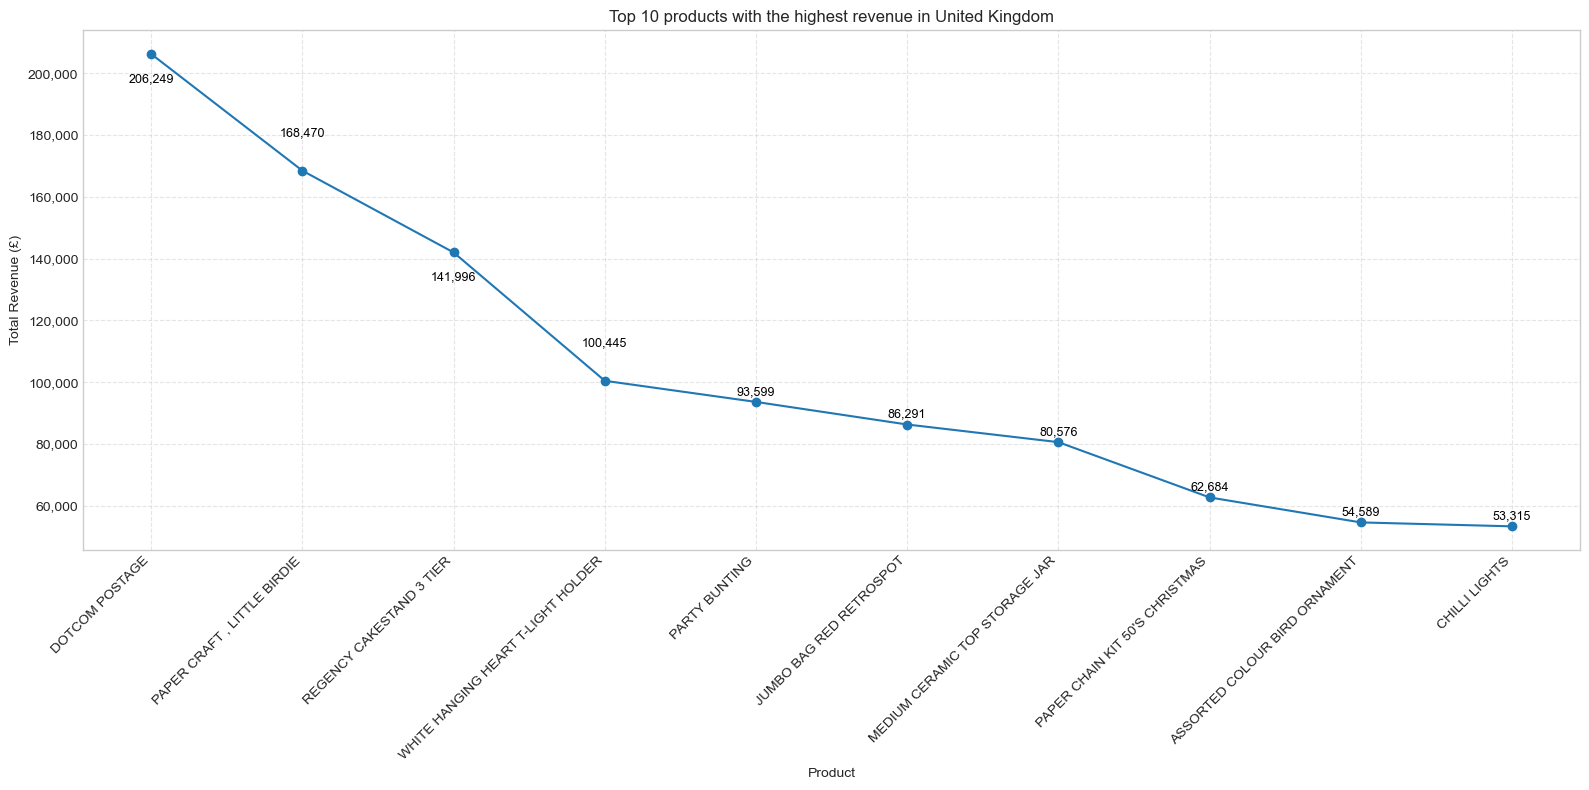

In [33]:
# Filtering data for United Kingdom
uk_data = data[data['Country'] == 'United Kingdom']

# Calculating total revenue by product
item_revenue = uk_data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)

# Getting the 10 products with the highest revenue
top_10_items = item_revenue.head(10)

# Plotting a line chart
plt.figure(figsize=(16, 8))
plt.plot(top_10_items.index, top_10_items.values, marker='o', color='tab:blue', linestyle='-')

# The list of products requiring annotation position adjustment

move_up_items = [
    'PAPER CRAFT , LITTLE BIRDIE',
    'WHITE HANGING HEART T-LIGHT HOLDER'
]

move_down_items = [
    'DOTCOM POSTAGE',
    'REGENCY CAKESTAND 3 TIER',
]

# Adding data labels to each point
for i, (desc, value) in enumerate(top_10_items.items()):
    # Defaulting offset_y
    offset_y = 5
    # If the product needs to be moved up
    if desc in move_up_items:
        offset_y += 20
    # If the product needs to be moved down
    elif desc in move_down_items:
        offset_y -= 25

    plt.annotate(f'{value:,.0f}',
                 (i, value),
                 textcoords="offset points",
                 xytext=(0, offset_y),
                 ha='center', fontsize=9, color='black')

# Formating the y-axis not in 1e6 notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Setting title and axis labels
plt.title('Top 10 products with the highest revenue in United Kingdom')
plt.xlabel('Product')
plt.ylabel('Total Revenue (£)')
plt.xticks(rotation=45, ha='right')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
print('Top 10 sản phẩm có doanh thu cao nhất thuộc về nước Anh (United Kingdom):')
plt.show()

Top 10 sản phẩm thuộc nước Anh (United Kingdom) được mua nhiều nhất:


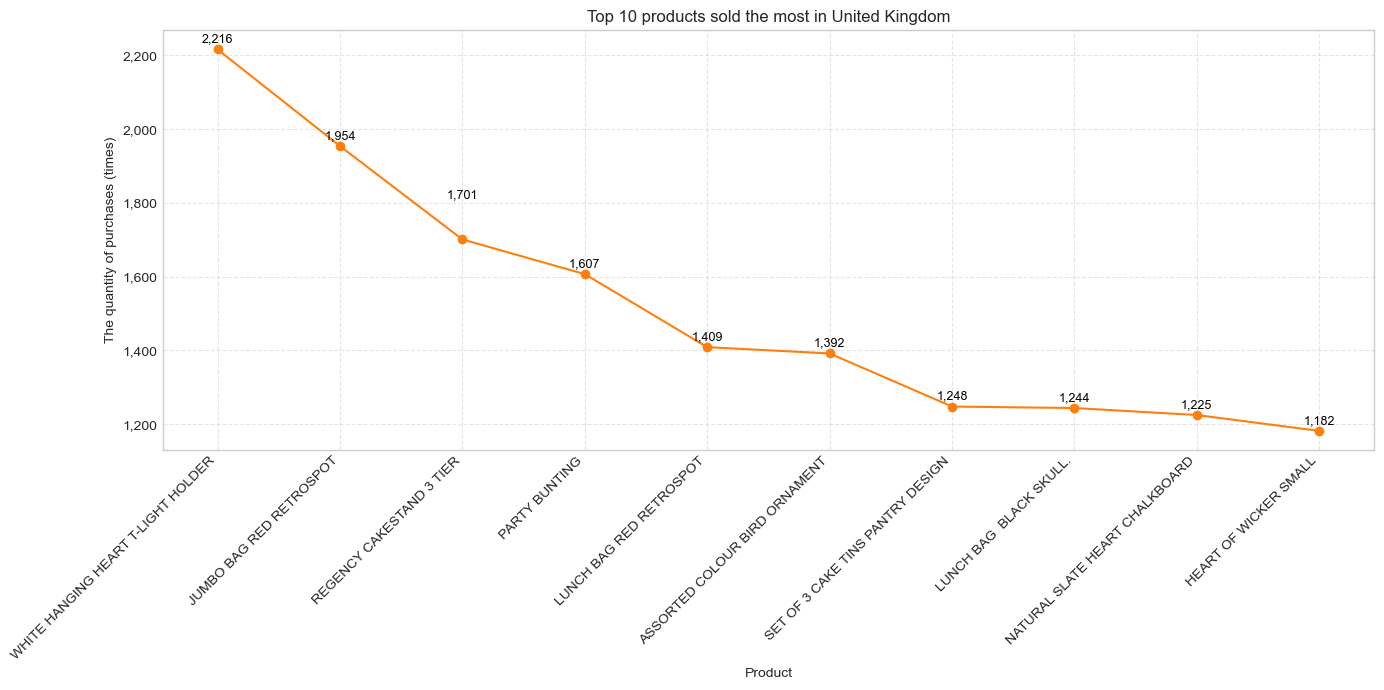

In [34]:
# Filtering data for United Kingdom
uk_data = data[data['Country'] == 'United Kingdom']

# Counting the number of purchases for each product
item_order_count = uk_data['Description'].value_counts().head(10)

# Plotting a line chart
plt.figure(figsize=(14, 7))
plt.plot(item_order_count.index, item_order_count.values, marker='o', color='tab:orange', linestyle='-')

# The list of products that need annotation position adjustment

move_up_items = [
    'JUMPO BAG RED RETROSPOT',
    'REGENCY CAKESTAND 3 TIER'
]


# Adding data labels on each point
for i, (desc, value) in enumerate(item_order_count.items()):
    # Defaulting offset_y
    offset_y = 5
    # If the product needs to be moved up
    if desc in move_up_items:
        offset_y += 25

    plt.annotate(f'{value:,.0f}',
                 (i, value),
                 textcoords="offset points",
                 xytext=(0, offset_y),
                 ha='center', fontsize=9, color='black')

# Formating the y-axis not in 1e6 notation
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Setting title and axis labels
plt.title('Top 10 products sold the most in United Kingdom')
plt.xlabel('Product')
plt.ylabel('The quantity of purchases (times)')
plt.xticks(rotation=45, ha='right')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
print('Top 10 sản phẩm thuộc nước Anh (United Kingdom) được mua nhiều nhất:')
plt.show()